> E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

I used counting method to build the trigram. The loss drop from `2.476470470428467` to `2.092747449874878`, which is a good improvement.

> E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

> E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

> E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

> E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

> E06: meta-exercise! Think of a fun/interesting exercise and complete it.

# Data loading

In [2]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

# Trigram counting

In [7]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    bigram = (ch1, ch2, ch3)
    b[bigram] = b.get(bigram, 0) + 1

In [8]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('a', 'h', '<E>'), 1714),
 (('n', 'a', '<E>'), 1673),
 (('a', 'n', '<E>'), 1509),
 (('o', 'n', '<E>'), 1503),
 (('<S>', 'm', 'a'), 1453),
 (('<S>', 'j', 'a'), 1255),
 (('<S>', 'k', 'a'), 1254),
 (('e', 'n', '<E>'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '<E>'), 953),
 (('a', 'r', 'i'), 950),
 (('i', 'a', '<E>'), 903),
 (('i', 'e', '<E>'), 858),
 (('a', 'n', 'n'), 825),
 (('e', 'l', 'l'), 822),
 (('a', 'n', 'a'), 804),
 (('i', 'a', 'n'), 790),
 (('m', 'a', 'r'), 776),
 (('i', 'n', '<E>'), 766),
 (('e', 'l', '<E>'), 727),
 (('y', 'a', '<E>'), 716),
 (('a', 'n', 'i'), 703),
 (('<S>', 'd', 'a'), 700),
 (('l', 'a', '<E>'), 684),
 (('e', 'r', '<E>'), 683),
 (('i', 'y', 'a'), 669),
 (('l', 'a', 'n'), 647),
 (('<S>', 'b', 'r'), 646),
 (('n', 'n', 'a'), 633),
 (('<S>', 'a', 'l'), 632),
 (('<S>', 'c', 'a'), 628),
 (('r', 'a', '<E>'), 627),
 (('n', 'i', '<E>'), 625),
 (('<S>', 'a', 'n'), 623),
 (('n', 'n', '<E>'), 619),
 (('n', 'e', '<E>'), 607),
 (('e', 'e', '<E>'), 605),
 (('e', 'y', '<

Trigram counting matrix

In [9]:
import torch

In [10]:
N = torch.zeros((27 * 27, 27), dtype=torch.int32)

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [12]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N[ix1 * 27 + ix2, ix3] += 1
    

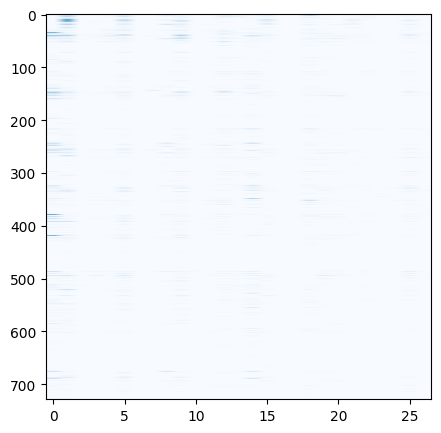

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(N, cmap='Blues')
plt.gca().set_aspect(1/27)

In [16]:
N[1]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

# Probability matrix

In [57]:
P =  N.float()
P /= N.sum(1, keepdim=True)
P.shape

torch.Size([729, 27])

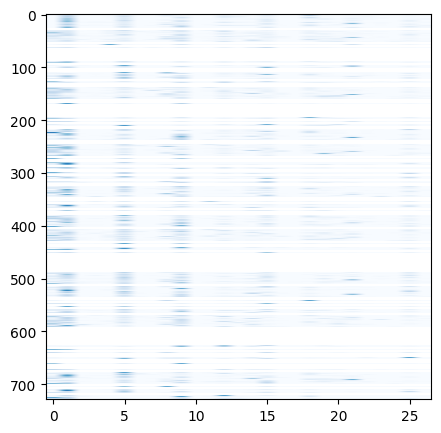

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(P, cmap='Blues')
plt.gca().set_aspect(1/27)

Smoothing

In [59]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

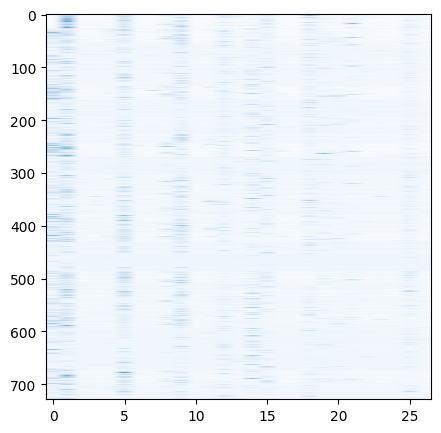

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(P, cmap='Blues')
plt.gca().set_aspect(1/27)

tensor(1.)

In [102]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []

  # start token
  N_start = N[:27, :].sum(1)
  p_start = N_start / N_start.sum()
  p_start.sum()

  ix = torch.multinomial(p_start, num_samples=1, replacement=True, generator=g).item()
  ix1 = ix // 27
  ix2 = ix - ix1 * 27
  
  # continue token
  while True:
    p = P[ix]

    ix1 = ix2
    ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    ix = 27 * ix1 + ix2
    
    out.append(itos[ix2])
    
    if ix2 == 0:
      break
    
  print(''.join(out))

unide.
akasid.
relay.
din.
airritoper.


# Estimation

In [165]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [110]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    prob = P[27 * ix1 + ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}{ch3}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878
